In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.cross_decomposition import PLSRegression, CCA, PLSSVD, PLSCanonical
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, LinearSVR
from sklearn.multioutput import MultiOutputRegressor
import warnings
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from MVA_algo import ReducedRankRegressor as RRR
from MVA_algo import OPLS
from AnchorOptimalProjector import AnchorOptimalProjection
from toy_models import *

In [2]:
# Setting ICML style
from tueplots import bundles

bundles.icml2022()
{'text.usetex': True, 'font.family': 'serif', 'text.latex.preamble': '\\usepackage{times} ', 'figure.figsize': (3.25, 2.0086104634371584), 'figure.constrained_layout.use': True, 'figure.autolayout': False, 'savefig.bbox': 'tight', 'savefig.pad_inches': 0.015, 'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 6, 'xtick.labelsize': 6, 'ytick.labelsize': 6, 'axes.titlesize': 8}

bundles.icml2022(family="sans-serif", usetex=False, column="full", nrows=2)
{'text.usetex': False, 'font.serif': ['Times'], 'mathtext.fontset': 'stix', 'mathtext.rm': 'Times', 'mathtext.it': 'Times:italic', 'mathtext.bf': 'Times:bold', 'font.family': 'sans-serif', 'figure.figsize': (6.75, 8.343458848123582), 'figure.constrained_layout.use': True, 'figure.autolayout': False, 'savefig.bbox': 'tight', 'savefig.pad_inches': 0.015, 'font.size': 8, 'axes.labelsize': 8, 'legend.fontsize': 6, 'xtick.labelsize': 6, 'ytick.labelsize': 6, 'axes.titlesize': 8}


# Plug any of those into either the rcParams or into an rc_context:

plt.rcParams.update(bundles.icml2022())

In [3]:
import matplotlib.colors as mcolors
# Create a colormap object using 'coolwarm'
cmap = plt.cm.get_cmap('coolwarm')
# Get the RGBA values for blue (minimum value in the colormap)
blue_rgba_1 = cmap(0.0)
blue_rgba_2 = cmap(0.25)
# Get the RGBA values for red (maximum value in the colormap)
red_rgba_1 = cmap(1.0)
red_rgba_2 = cmap(0.75)

In [4]:
# Setting up parameters
N = 20  # Number of interventions
n_iter = 10  # Number of iterations for each intervention
gamma_ar = 5  # anchor regularisation parameter
interventions = np.linspace(0, 4, N)  # Array of interventions

# List of gamma values including' PA', 'OLS', 'IV' and gamma=5
gammas = [0, 1, 'IV', gamma_ar]
# Number of gamma values
n_gammas = len(gammas)

# List of MVA algorithms
methods = [LinearRegression(), OPLS(ncp=5), RRR(rank=5), PLSRegression(5), CCA(5)]

# Number of methods
n_methods = len(methods)

# Array to store Mean Squared Errors (MSEs)
MSEs = np.zeros((len(methods), len(gammas), N))

# Suppressing warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    
    # Looping through methods and gammas
    for i in tqdm(range(len(methods))):  # Loop through methods
        for j in range(len(gammas)):  # Loop through gammas
            gamma = gammas[j]  # Current gamma value
            
            # Loop through interventions
            for k in range(N):
                t = interventions[k]  # Current intervention value
                mses = []  # List to store MSEs for each iteration
                
                # Iterating through iterations
                for n in range(n_iter):
                    np.random.seed(n)  # Setting random seed for reproducibility
                    
                    # Generating data for intervention
                    A_train, X_train, Y_train, A_test, X_test, Y_test, B_XY, N_Y_train, N_Y_test = gen_data(intervention=t, confounding=True)
                    
                    # Initializing and fitting Anchor Optimal Projection
                    AOP = AnchorOptimalProjection(gamma=gamma)
                    X_train_transform, Y_train_transform = AOP.fit_transform(A_train, X_train, Y_train)
                    
                    # Fitting the regression model
                    methods[i].fit(X_train_transform, Y_train_transform)
                    
                    # Predicting and calculating MSE
                    Y_pred = methods[i].predict(X_test)
                    mse = np.square(Y_test - Y_pred).mean()
                    mses.append(mse)  # Appending MSE to the list
                
                # Storing mean of MSEs for the current method, gamma, and intervention
                MSEs[i, j, k] = np.mean(mses)


100%|██████████████████████████████████████████████████████████| 5/5 [00:47<00:00,  9.60s/it]


In [5]:
# List of colors for plotting
colors = [blue_rgba_1, blue_rgba_2, red_rgba_2, red_rgba_1]

# List of line styles for plotting
line_styles = [':', '--', '-.', '-']

# Names for different gamma values
gammas_names = ['PA', 'unregularised', 'IV', r'Anchor($\gamma=5$)']

# Names for different regression methods
method_names = ['MLR', 'OPLS', 'RRR', 'PLS', 'CCA']

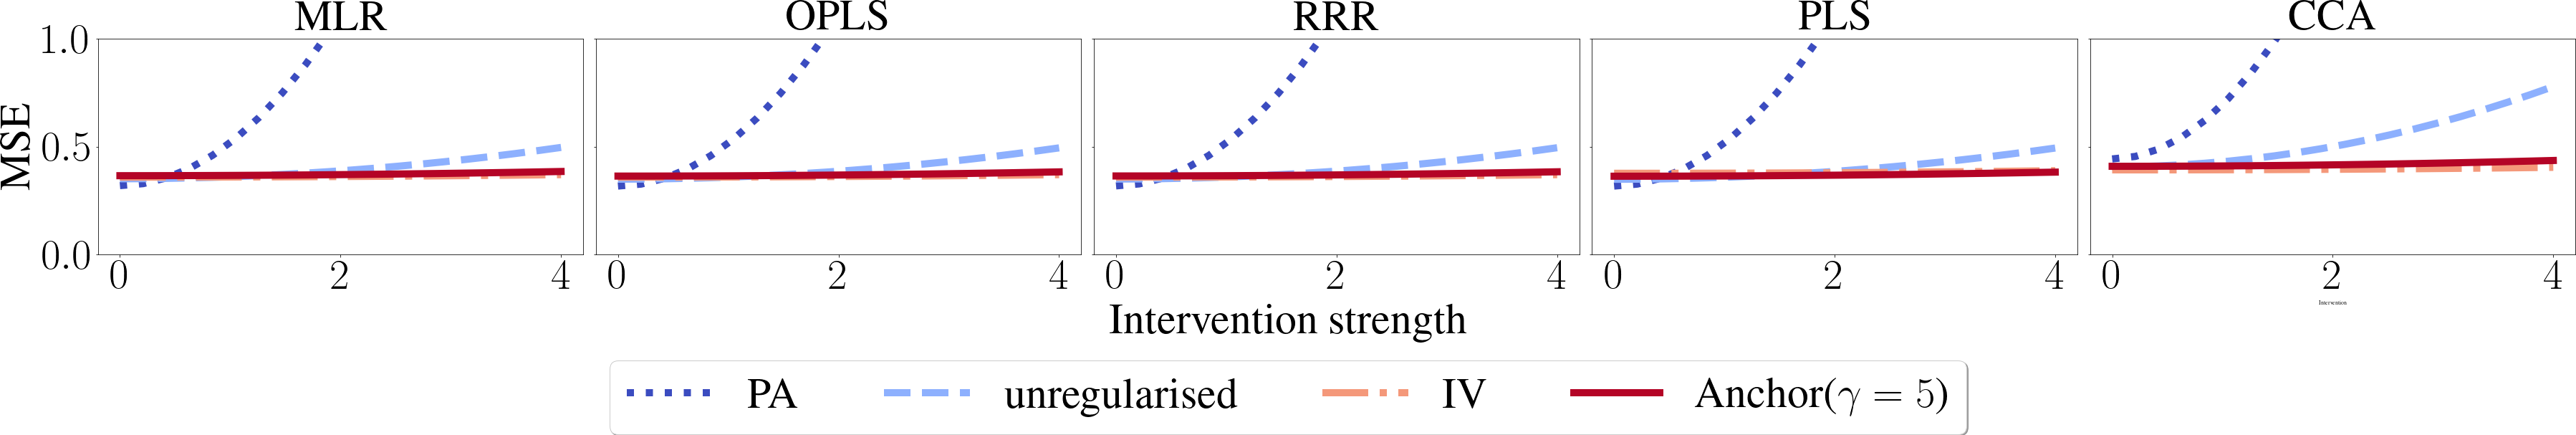

In [9]:
# Set larger fontsize
size = 60

# Creating subplots
fig, axs = plt.subplots(1, n_methods, figsize=(10 * n_methods, 6), sharey=True)

for method in range(n_methods):
    axs[method].set_title(f'{method_names[method]}', fontsize=size)

    for i, gamma in enumerate(range(n_gammas)):
        # Extracting values for the last dimension
        y_values = MSEs[method, gamma, :]

        # Plotting lines with different line styles
        axs[method].plot(interventions, y_values, label=f'{gammas_names[gamma]}', linewidth=10, c=colors[i], linestyle=line_styles[i])

# Placing the legend outside the subplots
handles, labels = axs[method].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=n_gammas, fontsize=size)

# Set common x-axis label
fig.text(0.5, -0.08, 'Intervention strength', ha='center', fontsize=size)

# Set y-axis label
axs[0].set_ylabel('MSE', fontsize=size)

# Set larger fontsize for x and y axis tick labels
for ax in axs.flat:
    ax.tick_params(axis='both', labelsize=size)

plt.ylim(0, 1)

# Saving the plot 
directory = '../results'
plt.savefig(directory + "/perturbation_strength_robustness_anchor.pdf", format="pdf", bbox_inches="tight")

plt.xlabel('Intervention')
plt.show()
